The first part of this assignment requires to estimate a well-suited sub-sample size for evaluating the prompt engineering based approaches
to sentiment analysis on the IMDB40k dataset.
To this end, we need to conduct power analysis in the context of paired samples - as we will be comparing pairs of models on the same sample.
To calculate the sample size needed for a desired significance level and power we apply the following formula:

$$n = \left( \frac{(z_{1-\alpha/2} + z_{1-\beta}) \cdot \sigma_{\Delta_{AB}}}{\mu_{\Delta_{AB}}} \right)^2$$

where:

$\mu_{\Delta_{AB}}=acc(A) - acc(B)$ is the expected minimum detectable difference between the two models.

$\sigma^2_{\Delta_{AB}}=p(A\lnot B) + p(B\lnot A)$ is the estimate of the variance of the per-instance differences.

$z_{1-\alpha/2}$ and  $z_{1-\beta}$ are the z-score thresholds for a confidence level $\alpha$ and beta rist $\beta$.

---

Plugging the expected accuracies .91 and .94 and estimating the variance of the difference as .10 we get for a confidence level of $\textbf{.05}$ and beta risk of $\textbf{.1}$ we get ~ $\textbf{1122}$
If we take e.g. a minimum detectable difference of .02 we will need >2500 samples. For the current task I recon a .03 resolution is fine enough, taking into account the time
constraints and the need to evaluate as many as possible different scenarios.

In [1]:
import sys
sys.path.append("..")
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from eda_utils.preprocessing_pipeline_eda import PreprocessingPipelineEDA
from eda_utils.plots import plot_side_by_side_hists
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_json("../data/imdb-movie-reviews/train.jsonl", lines = True)

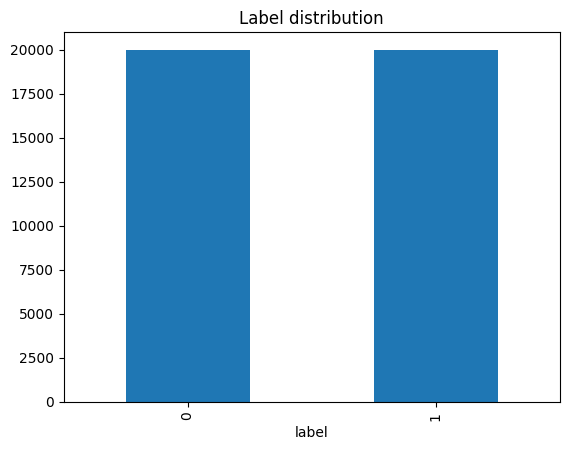

In [3]:
_ = data.label.value_counts().plot.bar(title = "Label distribution")

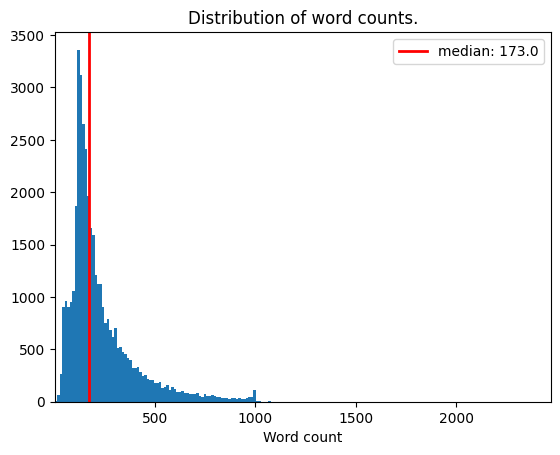

In [4]:
data.loc[:, "_word_counts"] = data.review.str.split().str.len()
ax = data._word_counts.hist(bins=200, grid=False)
_ = ax.set_xlim(data._word_counts.min(), data._word_counts.max()) 
_ = ax.axvline(x=data._word_counts.quantile(0.5), color='red', linewidth=2, label=f"median: {data._word_counts.quantile(0.5)}")
_ = ax.legend()
_ = ax.set_xlabel("Word count")
_ = ax.set_title("Distribution of word counts.")

In [5]:
counts, bin_edges = np.histogram(data._word_counts, bins = 100)

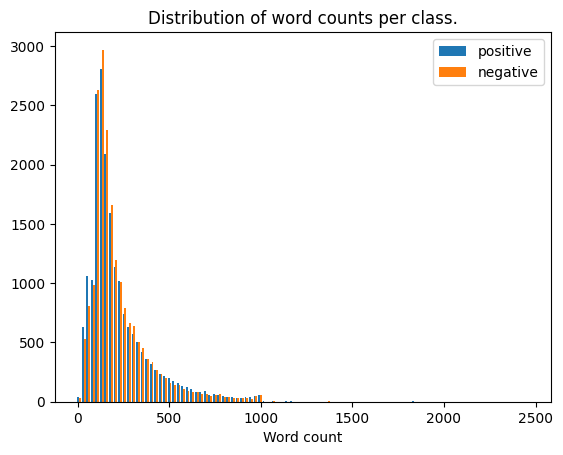

In [6]:
plot_side_by_side_hists(data, bin_edges)

We want to keep the perfect balance of the dataset and keep the distribution of text lengths.

In [7]:
edges = np.concat([bin_edges[1:][counts>100], bin_edges[-1:]])

In [8]:
data.loc[:, "size_groups"] = np.digitize(data._word_counts, edges, right=True)

### Discover topics
The next step is to explore this subsample and to extract a diverse final dataset in terms of topics. We only do the previous step in order to reduce the time needed for the processing.

In [17]:
_, subsample = train_test_split(data, test_size = 10000, stratify=data[["label", "size_groups"]])

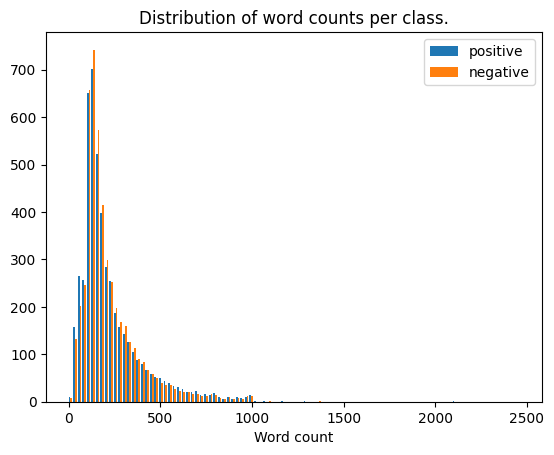

In [18]:
plot_side_by_side_hists(subsample, bin_edges)

In [11]:
pipeline = PreprocessingPipelineEDA(allowed_pos_tags = ["ADJ", "ADV", "NOUN", "PROPN", "VERB"])

In [211]:
%%time
processed = pipeline.multiprocessed_processing(subsample.review)

CPU times: user 37.6 ms, sys: 118 ms, total: 156 ms
Wall time: 29.5 s


In [212]:
processed[0]

'carla secretari essenti deaf hear aid find overload work abl hire paul help paul just jail past entir say too much more stori mani twist most interest thing film sound use indic carla hear sort point hear point view earli scene set as well earli charact develop carla paul more interest twist turn later on hard follow stretch credibl bit also unpleas violenc back posit side cinematographi veri film worth see perhap seek seen san francisco intern film festiv'

In [213]:
vectorizer = CountVectorizer(max_df=0.98, min_df=5, stop_words='english')
X_counts = vectorizer.fit_transform(processed)

In [223]:
%%time
lda = LatentDirichletAllocation(n_components=50, random_state=42, n_jobs=-1)
X_topics = lda.fit_transform(X_counts)

CPU times: user 2.03 s, sys: 163 ms, total: 2.19 s
Wall time: 15 s


In [224]:
k_values = np.arange(5, 201, 5)

In [225]:
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_topics)
    score = silhouette_score(X_topics, cluster_labels)
    silhouette_scores.append(score)

In [226]:
best_score_idx = np.argmax(silhouette_scores)

In [227]:
len(k_values)

40

Text(0.5, 1.0, 'Silhouette score')

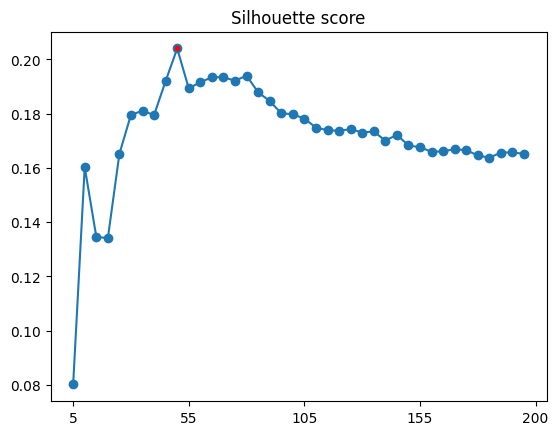

In [228]:
plt.plot(silhouette_scores, "-o", zorder = 1)
plt.scatter(best_score_idx, silhouette_scores[best_score_idx], color = "r",s = 10 )
plt.xticks(ticks = np.arange(0, len(k_values)+1, 10), labels = list(k_values[::10]) + [k_values[-1]])
plt.title("Silhouette score")

In [262]:
kmeans = KMeans(n_clusters=k_values[best_score_idx], random_state=42)
cluster_labels = kmeans.fit_predict(X_topics)

In [263]:
subsample.loc[:, "cluster_labels"] = cluster_labels

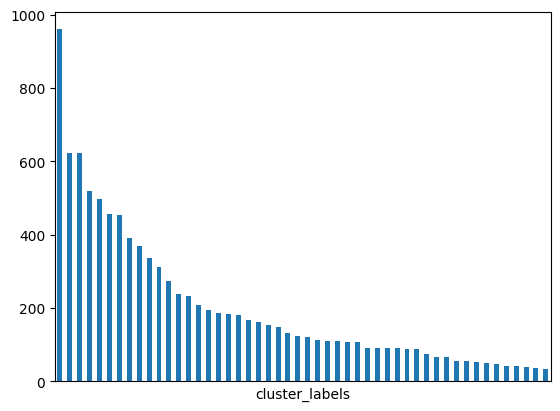

In [264]:
ax = subsample.cluster_labels.value_counts().plot.bar()
_ = ax.set_xticks(ticks = [])

<Axes: xlabel='cluster_labels'>

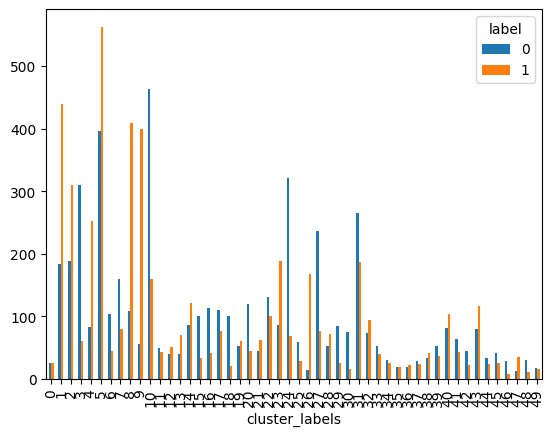

In [265]:
subsample.groupby(["label", "cluster_labels"]).size().unstack("label").plot.bar()

We see here however that the the differences are way too big between the labels - i.e. it might be that the LDA also encodes sentiment instead of movie topics. I will not 
be using it in the further dataset subsampling as it seems too risky of unnecessary error propagation. More advanced semantic embedding models / more sophisticated preprocessing? should be used to acquire 
better performance, which is out of scope of the current task.

In [51]:
others_negative, subsample_negative = train_test_split(data[data.label==1], test_size = int(1122/2), stratify=data[data.label==1][["size_groups"]], random_state=42)

In [52]:
others_positive, subsample_positive = train_test_split(data[data.label==0], test_size = int(1122/2), stratify=data[data.label==0][["size_groups"]], random_state=42)

In [53]:
subsample = pd.concat([subsample_positive, subsample_negative])[["review", "label"]]

In [56]:
subsample.sample(len(subsample)).to_json("../data/subsample.jsonl", lines=True, orient="records")